### Libraries for Gradient Boosting Tree

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import *

### Read in the csv file containing the data of interest and show the head

In [2]:
enteroData = pd.read_csv('enteroData.csv')
print(enteroData.shape)
enteroData.head()

(3560, 9)


,Sample Date,Enterococci Results,Year Population,Day Before Precipitation,Day of Precipitation,Water Temperature,Sum Precip,Month,Year
0,6/1/2005,4.0,7939571,0.0,0.0,15.23,0.0,6,2005
1,6/1/2005,4.0,7939571,0.0,0.0,15.23,0.0,6,2005
2,6/1/2005,4.0,7939571,0.0,0.0,15.23,0.0,6,2005
3,6/1/2005,4.0,7939571,0.0,0.0,15.23,0.0,6,2005
4,6/8/2005,4.0,7939571,0.0,0.0,17.89,0.0,6,2005


### Data Reduction for CSO Rainfall Data

CSOs typically occur when there is rain intensity of 0.1 in/hr, therefore under the assumption that the average storm lasts 30 minutes, 0.05 inches of rainfall during is possibly associated with this intensity and so will be used as the basis for reducing our data:

In [3]:
wetData = enteroData[(enteroData['Day Before Precipitation'] > 0.05) | (enteroData['Day of Precipitation'] > 0.05)]

print(wetData.shape)
wetData.head()

(1408, 9)


,Sample Date,Enterococci Results,Year Population,Day Before Precipitation,Day of Precipitation,Water Temperature,Sum Precip,Month,Year
54,5/30/2006,4.0,7904335,0.20,0.00,15.92,0.20,5,2006
55,5/30/2006,4.0,7904335,0.20,0.00,15.92,0.20,5,2006
56,5/30/2006,4.0,7904335,0.20,0.00,15.92,0.20,5,2006
69,6/27/2006,4.0,7904335,0.06,0.05,19.44,0.11,6,2006
70,6/27/2006,4.0,7904335,0.06,0.05,19.44,0.11,6,2006


### Looking at average values to see how the correlations differ

In [4]:
enteroAvgData = pd.read_csv('enteroDataAvg.csv')

print(enteroAvgData.shape)
enteroAvgData.head()

(325, 9)


,Sample Date,Enterococci Results,Year Population,Day Before Precipitation,Day of Precipitation,Water Temperature,Sum Precip,Month,Year
0,6/1/2005,9.846154,7939571,0.0,0.00,15.23,0.00,6,2005
1,6/8/2005,24.923077,7939571,0.0,0.00,17.89,0.00,6,2005
2,6/14/2005,4.000000,7939571,0.0,0.00,19.17,0.00,6,2005
3,6/20/2005,33.200000,7939571,0.0,0.00,18.56,0.00,6,2005
4,7/5/2005,4.800000,7939571,0.0,0.04,21.23,0.04,7,2005


In [5]:
wetAvgData = enteroAvgData[(enteroAvgData['Day Before Precipitation'] > 0.05) | (enteroAvgData['Day of Precipitation'] > 0.05)]

print(wetAvgData.shape)
wetAvgData.head()

(114, 9)


,Sample Date,Enterococci Results,Year Population,Day Before Precipitation,Day of Precipitation,Water Temperature,Sum Precip,Month,Year
17,5/30/2006,52.000000,7904335,0.20,0.00,15.92,0.20,5,2006
20,6/27/2006,8.000000,7904335,0.06,0.05,19.44,0.11,6,2006
21,7/5/2006,16.615385,7904335,0.00,1.06,19.92,1.06,7,2006
23,7/18/2006,23.714286,7904335,0.00,0.44,22.11,0.44,7,2006
39,6/19/2007,6.857143,7908735,0.00,0.06,20.72,0.06,6,2007


Defining Dependent Variable

In [6]:
# The dependent variable, also called the label, is what we are trying to predict
# The labels DataFrame is first initiated like this for the visual representation
enteroLabels = pd.DataFrame({"Enterococci Results": enteroData['Enterococci Results']})
print(enteroLabels.shape)
enteroLabels.head()

(3560, 1)


,Enterococci Results
0,4.0
1,4.0
2,4.0
3,4.0
4,4.0


In [7]:
wetLabels = pd.DataFrame({"Enterococci Results": wetData['Enterococci Results']})
print(wetLabels.shape)
wetLabels.head()

(1408, 1)


,Enterococci Results
54,4.0
55,4.0
56,4.0
69,4.0
70,4.0


In [8]:
enteroAvgLabels = pd.DataFrame({"Enterococci Results": enteroAvgData['Enterococci Results']})
print(enteroAvgLabels.shape)
enteroAvgLabels.head()

(325, 1)


,Enterococci Results
0,9.846154
1,24.923077
2,4.000000
3,33.200000
4,4.800000


In [9]:
wetAvgLabels = pd.DataFrame({"Enterococci Results": wetAvgData['Enterococci Results']})
print(wetAvgLabels.shape)
wetAvgLabels.head()

(114, 1)


,Enterococci Results
17,52.000000
20,8.000000
21,16.615385
23,23.714286
39,6.857143


In [10]:
# This is done to put the dataframe back into the format for the model
labels = enteroData['Enterococci Results']
wetLabels = wetData['Enterococci Results']

avgLabels = enteroAvgData['Enterococci Results']
wetAvgLabels = wetAvgData['Enterococci Results']

Defining Independent Variables/Predictors

In [11]:
# Dropping dependent variable and Date
features = enteroData.drop('Enterococci Results', axis=1)
features = features.drop('Sample Date', axis=1)

print(features.shape)
features.head()

(3560, 7)


,Year Population,Day Before Precipitation,Day of Precipitation,Water Temperature,Sum Precip,Month,Year
0,7939571,0.0,0.0,15.23,0.0,6,2005
1,7939571,0.0,0.0,15.23,0.0,6,2005
2,7939571,0.0,0.0,15.23,0.0,6,2005
3,7939571,0.0,0.0,15.23,0.0,6,2005
4,7939571,0.0,0.0,17.89,0.0,6,2005


In [12]:
wetFeatures = wetData.drop('Enterococci Results', axis=1)
wetFeatures = wetFeatures.drop('Sample Date', axis=1)

print(wetFeatures.shape)
wetFeatures.head()

(1408, 7)


,Year Population,Day Before Precipitation,Day of Precipitation,Water Temperature,Sum Precip,Month,Year
54,7904335,0.20,0.00,15.92,0.20,5,2006
55,7904335,0.20,0.00,15.92,0.20,5,2006
56,7904335,0.20,0.00,15.92,0.20,5,2006
69,7904335,0.06,0.05,19.44,0.11,6,2006
70,7904335,0.06,0.05,19.44,0.11,6,2006


In [13]:
avgFeatures = enteroAvgData.drop('Enterococci Results', axis=1)
avgFeatures = avgFeatures.drop('Sample Date', axis=1)

print(avgFeatures.shape)
avgFeatures.head()

(325, 7)


,Year Population,Day Before Precipitation,Day of Precipitation,Water Temperature,Sum Precip,Month,Year
0,7939571,0.0,0.00,15.23,0.00,6,2005
1,7939571,0.0,0.00,17.89,0.00,6,2005
2,7939571,0.0,0.00,19.17,0.00,6,2005
3,7939571,0.0,0.00,18.56,0.00,6,2005
4,7939571,0.0,0.04,21.23,0.04,7,2005


In [14]:
wetAvgFeatures = wetAvgData.drop('Enterococci Results', axis=1)
wetAvgFeatures = wetAvgFeatures.drop('Sample Date', axis=1)

print(wetAvgFeatures.shape)
wetAvgFeatures.head()

(114, 7)


,Year Population,Day Before Precipitation,Day of Precipitation,Water Temperature,Sum Precip,Month,Year
17,7904335,0.20,0.00,15.92,0.20,5,2006
20,7904335,0.06,0.05,19.44,0.11,6,2006
21,7904335,0.00,1.06,19.92,1.06,7,2006
23,7904335,0.00,0.44,22.11,0.44,7,2006
39,7908735,0.00,0.06,20.72,0.06,6,2007


### Making Data into NumPy Arrays

In [15]:
features = np.array(features)
wetFeatures = np.array(wetFeatures)
avgFeatures = np.array(avgFeatures)
wetAvgFeatures = np.array(wetAvgFeatures)

labels = np.array(labels)
wetLabels = np.array(wetLabels)
avgLabels = np.array(avgLabels)
wetAvgFeatures = np.array(wetAvgFeatures)

### We will now split our dataset into training data and testing data

In [16]:
# As mentioned in article, we want our results to be reproducible, so we use a random_state = 21
trainFeatures, testFeatures, trainLabels, testLabels = train_test_split(features, labels, test_size = 0.2, random_state = 21)

print(trainFeatures.shape)
print(testFeatures.shape)
print(trainLabels.shape)
print(testLabels.shape)

(2848, 7)
(712, 7)
(2848,)
(712,)


## Creating the model

### Gradient Boosting Tree

We will first use base parameters to see the performance of the random forest under these conditions

In [17]:
params_gbt = {'n_estimators':1000,
              'criterion':'friedman_mse', 
              'loss': 'squared_error',
              'ccp_alpha': 0,
              'max_depth': 10,
              'min_samples_leaf':1,
              'min_samples_split':5,
              'max_features':None}

gbt = GradientBoostingRegressor(**params_gbt)

gbt.fit(trainFeatures,trainLabels)

GradientBoostingRegressor(ccp_alpha=0, max_depth=10, min_samples_split=5,
                          n_estimators=1000)

Making Predictions

(0.6398269271091086, 3.0479319221032353e-83)

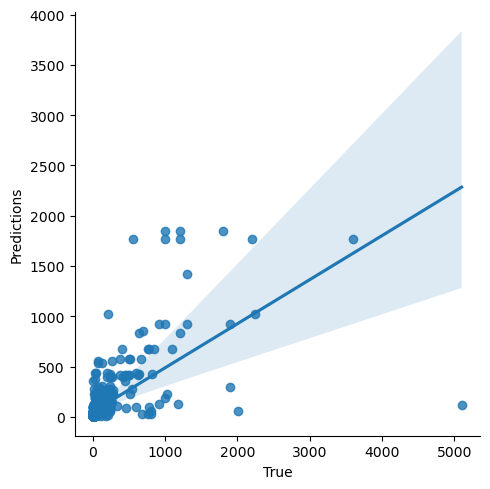

In [18]:
enteroPredictions = gbt.predict(testFeatures)
comp = pd.DataFrame({'True': testLabels, 'Predictions':enteroPredictions})

sns.lmplot(x = 'True', y='Predictions', data=comp)

stats.pearsonr(comp['True'], comp['Predictions'])

In [19]:
error = (enteroPredictions - testLabels)**2
print('Mean Squared Error:', round(np.mean(error), 2), 'cells/100mL.')

error = abs(enteroPredictions - testLabels)
print('Mean Absolute Error:', round(np.mean(error), 2), 'cells/100mL.')

Mean Squared Error: 72059.38 cells/100mL.
Mean Absolute Error: 71.28 cells/100mL.


We can then look to find optimal hyperparameters by doing the following:

In [20]:
# Using methods from class
random_grid = {'n_estimators': randint(4, 2000),
               'criterion': ['friedman_mse'],
               'loss': ['squared_error', 'absolute_error'],
               'max_features': truncnorm(a=0, b=1, loc=0.25, scale=0.1),
               'max_depth': randint(3, 1000),
               'min_samples_split': uniform(0.01, 0.499),
               'min_samples_leaf': uniform(0.01, 0.499),
               'ccp_alpha': uniform(0.000, 0.100)}

gbt2 = GradientBoostingRegressor(random_state=21)
gbt_random = RandomizedSearchCV(estimator = gbt2, param_distributions = random_grid, 
                                n_iter = 50, cv = 15, random_state = 21)
gbt_entero = gbt_random.fit(trainFeatures,trainLabels)
print("The best hyperparameters: \n",gbt_entero.best_params_)

KeyboardInterrupt: 

(0.6286702965774875, 1.38763179125462e-79)

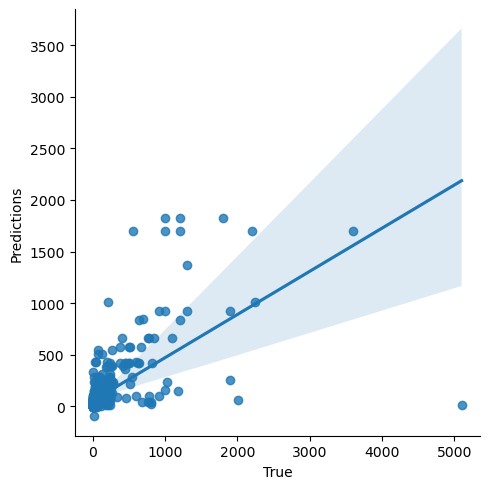

In [ ]:
enteroPredictions = gbt_entero.predict(testFeatures)
comp = pd.DataFrame({'True': testLabels, 'Predictions':enteroPredictions})

sns.lmplot(x = 'True', y='Predictions', data=comp)

stats.pearsonr(comp['True'], comp['Predictions'])

In [ ]:
error = (enteroPredictions - testLabels)**2
print('Mean Squared Error:', round(np.mean(error), 2), 'cells/100mL.')

error = abs(enteroPredictions - testLabels)
print('Mean Absolute Error:', round(np.mean(error), 2), 'cells/100mL.')

Mean Squared Error: 73691.03 cells/100mL.
Mean Absolute Error: 75.41 cells/100mL.


### Now an analysis will be done on whether or not the model can improve at higher values, if values below the CSO threshold are omitted

In [ ]:
# As mentioned in article, we want our results to be reproducible, so we use a random_state = 21
trainFeatures, testFeatures, trainLabels, testLabels = train_test_split(wetFeatures, wetLabels, test_size = 0.2, random_state = 21)

In [ ]:
wetGbt = GradientBoostingRegressor(**params_gbt)

wetGbt.fit(trainFeatures,trainLabels)

GradientBoostingRegressor(ccp_alpha=0, max_depth=10, min_samples_split=5,
                          n_estimators=1000)

(0.7231566518175372, 6.540134595263089e-47)

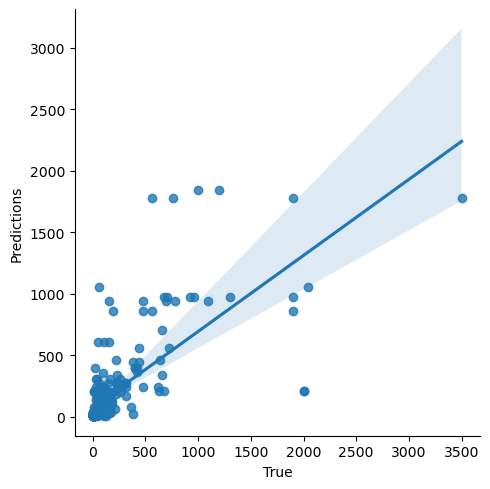

In [ ]:
enteroPredictions = wetGbt.predict(testFeatures)
comp = pd.DataFrame({'True': testLabels, 'Predictions':enteroPredictions})

sns.lmplot(x = 'True', y='Predictions', data=comp)
stats.pearsonr(comp['True'], comp['Predictions'])

In [ ]:
error = (enteroPredictions - testLabels)**2
print('Mean Squared Error:', round(np.mean(error), 2), 'cells/100mL.')

error = abs(enteroPredictions - testLabels)
print('Mean Absolute Error:', round(np.mean(error), 2), 'cells/100mL.')

Mean Squared Error: 77155.11 cells/100mL.
Mean Absolute Error: 108.62 cells/100mL.


In [ ]:
# Using methods from class
random_grid = {'n_estimators': randint(4, 2000),
               'criterion': ['friedman_mse'],
               'loss': ['squared_error', 'absolute_error'],
               'max_features': truncnorm(a=0, b=1, loc=0.25, scale=0.1),
               'max_depth': randint(3, 1000),
               'min_samples_split': uniform(0.01, 0.499),
               'min_samples_leaf': uniform(0.01, 0.499),
               'ccp_alpha': uniform(0.000, 0.100)}

gbt3 = GradientBoostingRegressor(random_state=21)
gbt_random = RandomizedSearchCV(estimator = gbt3, param_distributions = random_grid, 
                                n_iter = 50, cv = 15, random_state = 21)
wetGbt_entero = gbt_random.fit(trainFeatures,trainLabels)
print("The best hyperparameters: \n",wetGbt_entero.best_params_)

The best hyperparameters: 
 {'ccp_alpha': 0.0975578748205733, 'criterion': 'friedman_mse', 'loss': 'squared_error', 'max_depth': 66, 'max_features': 0.28003465651732456, 'min_samples_leaf': 0.021390321620189452, 'min_samples_split': 0.5082736749772433, 'n_estimators': 768}


(0.7099055165366699, 1.5735897779135064e-44)

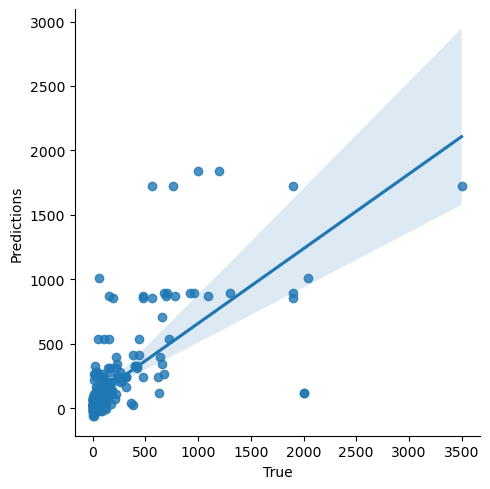

In [ ]:
enteroPredictions = wetGbt_entero.predict(testFeatures)
comp = pd.DataFrame({'True': testLabels, 'Predictions':enteroPredictions})

sns.lmplot(x = 'True', y='Predictions', data=comp)
stats.pearsonr(comp['True'], comp['Predictions'])

In [ ]:
error = (enteroPredictions - testLabels)**2
print('Mean Squared Error:', round(np.mean(error), 2), 'cells/100mL.')

error = abs(enteroPredictions - testLabels)
print('Mean Absolute Error:', round(np.mean(error), 2), 'cells/100mL.')

Mean Squared Error: 79133.44 cells/100mL.
Mean Absolute Error: 117.14 cells/100mL.


### Applying Original GBT to the wet data

In [ ]:
enteroPredictions = gbt_entero.predict(testFeatures)
comp = pd.DataFrame({'True': testLabels, 'Predictions':enteroPredictions})

sns.lmplot(x = 'True', y='Predictions', data=comp)
stats.pearsonr(comp['True'], comp['Predictions'])

In [ ]:
error = (enteroPredictions - testLabels)**2
print('Mean Squared Error:', round(np.mean(error), 2), 'cells/100mL.')

error = abs(enteroPredictions - testLabels)
print('Mean Absolute Error:', round(np.mean(error), 2), 'cells/100mL.')